In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import share_states, share_sale, env_infos, count_sales_first_session, get_beta_confidence_interval

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False
num_products = env_1_sale_args['num_products']

In [2]:
num_users = 100
data = deepcopy(env).generate_logs(num_users)
display(data)
data.to_csv("generate_logs_test.csv")

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.85it/s]


,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,1,<NA>,NaN,NaN,NaN,None
1,1.0,0,organic,4,<NA>,NaN,NaN,NaN,None
2,2.0,0,bandit,<NA>,2,0.0,0.0,0.1,()
3,3.0,0,bandit,<NA>,8,0.0,0.0,0.1,()
4,4.0,0,bandit,<NA>,4,0.0,0.0,0.1,()
...,...,...,...,...,...,...,...,...,...
10335,6.0,99,bandit,<NA>,7,0.0,0.0,0.1,()
10336,7.0,99,bandit,<NA>,7,0.0,0.0,0.1,()
10337,8.0,99,bandit,<NA>,8,0.0,0.0,0.1,()
10338,9.0,99,bandit,<NA>,5,0.0,0.0,0.1,()


In [ ]:
data["z"]

In [3]:
print(share_states(data))
print("\nShare of sales (binary or total) wrt nb bandit events : ",share_sale(data))

print("Share of sales among organic events :", sum(data["z"]=="sale")/sum(data["z"]=="organic"))
print("Number of sales over nb of organic events :", sum(data["r"][data['r']>0])/sum(data["z"]=="organic"))
sales, no_event = count_sales_first_session(data)
print("Share of first organic sessions with sale before reco : ",np.sum(list(sales.values()))/len(data['u'].unique()))

{'organic': 0.2190522243713733, 'bandit': 0.7500967117988394, 'sale': 0.030851063829787233}

Share of sales (binary or total) wrt nb bandit events :  {'sale_bin': 0.025141825683341928, 'sale_tot': 0.03468282619907169}
Share of sales among organic events : 0.14083885209713023
Number of sales over nb of organic events : 0.11876379690949228
Share of first organic sessions with sale before reco :  0.36


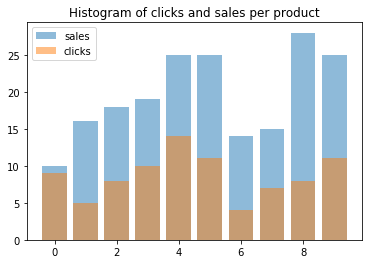

In [4]:
clicked_actions = data[data['z'] == 'bandit'].loc[data['c'] == 1]['a'] 
click_actions, total_clicks = np.unique(clicked_actions, return_counts=True)

rewarded_actions = data[data['z'] == 'bandit'].loc[data['r'] > 0]['a'] 
sale_actions, total_rewards = np.unique(rewarded_actions, return_counts=True)


plt.bar(sale_actions, total_rewards, label = "sales",alpha=0.5)
plt.bar(click_actions, total_clicks, label = "clicks",alpha=0.5)
plt.legend()
plt.title('Histogram of clicks and sales per product')
plt.show()

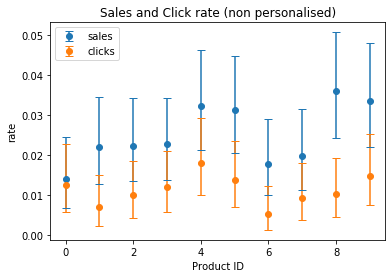

In [7]:
sales = np.zeros(num_products)
clicks = np.zeros(num_products)
lower_errors = np.zeros(num_products)
upper_errors = np.zeros(num_products)
LB_errors = np.zeros(num_products)
UB_errors = np.zeros(num_products)
action_counts = np.unique(data[data['z'] == 'bandit']['a'], return_counts=True)[1]
actions = range(num_products)

for product_id in actions:
    n_impressions = action_counts[product_id]
    n_sales = total_rewards[product_id]
    n_clicks = total_clicks[product_id]
    
    lower_bound, upper_bound = get_beta_confidence_interval(n_impressions, n_sales)
    LB, UB = get_beta_confidence_interval(n_impressions, n_clicks)
    
    sales[product_id] = n_sales / n_impressions
    clicks[product_id] = n_clicks / n_impressions
    
    lower_errors[product_id] = lower_bound
    upper_errors[product_id] = upper_bound
    
    LB_errors[product_id] = LB
    UB_errors[product_id] = UB

plt.title('Sales and Click rate (non personalised)')

plt.errorbar(
    actions, sales, yerr=(lower_errors, upper_errors),
    fmt='o', capsize=4, label = "sales")

plt.errorbar(
    actions, clicks, yerr=(LB_errors, UB_errors),
    fmt='o', capsize=4, label = "clicks")

plt.xlabel('Product ID')
plt.ylabel('rate')
plt.legend()
plt.show()

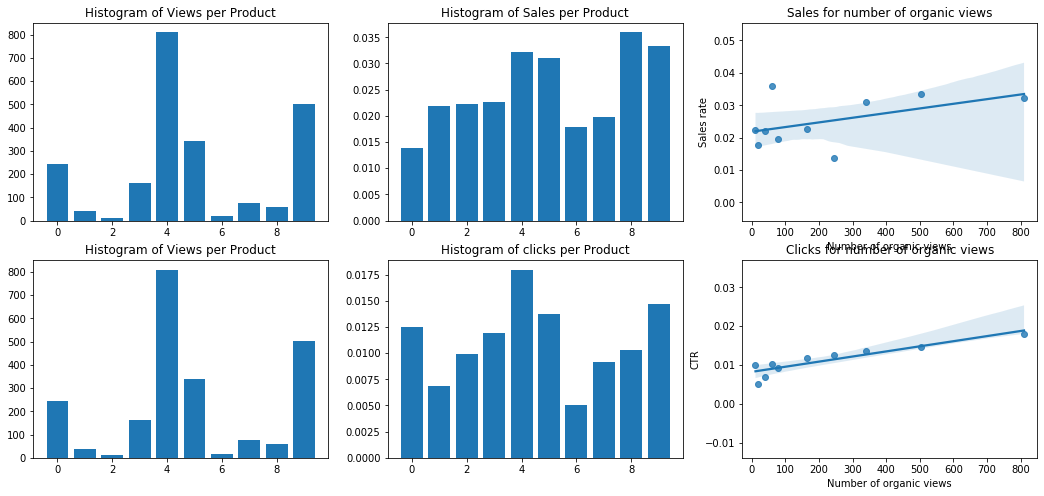

In [8]:
import seaborn as sns
product_views =  data[data['z'] == 'organic']['v']
products, views_counts = np.unique(product_views, return_counts=True)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes[0,0].set_title('Histogram of Views per Product')
axes[0,0].bar(products, views_counts)

axes[0,1].set_title('Histogram of Sales per Product')
axes[0,1].bar(products, sales)

sns.regplot(views_counts, sales, ax=axes[0,2])
axes[0,2].set_title('Sales for number of organic views')
axes[0,2].set_xlabel('Number of organic views')
axes[0,2].set_ylabel('Sales rate')

axes[1,0].set_title('Histogram of Views per Product')
axes[1,0].bar(products, views_counts)

axes[1,1].set_title('Histogram of clicks per Product')
axes[1,1].bar(products, clicks)

sns.regplot(views_counts, clicks, ax=axes[1,2])
axes[1,2].set_title('Clicks for number of organic views')
axes[1,2].set_xlabel('Number of organic views')
axes[1,2].set_ylabel('CTR')

plt.show()

## Sales figures for different agents

In [9]:
from recogym.envs.utils_sale import check_sales, PopularityAgent
from recogym.agents import RandomAgent, random_args
from recogym.envs.utils_sale import SingleActionAgent

In [10]:
list_agents = {
    'Random': RandomAgent(Configuration({
    **env_1_sale_args,
    **random_args,
})),

    
    'Popularity': PopularityAgent(Configuration({
    **env_1_sale_args,
    'num_products': num_products,
})),
    
    'greedy_bandit' : SingleActionAgent(np.argmax([data["r"][data['a']==a].sum() for a in range(num_products)]), 
                                  Configuration(env_1_sale_args)),
    
    'greedy_organic' : SingleActionAgent(np.argmax(np.unique(data[data['z'] == 'organic']['v'], return_counts=True)[1]), 
                                   Configuration(env_1_sale_args))
    }

In [11]:
num_online_users = 100
list_perfs = {}
for name,agent in list_agents.items():
    print("====================================================")
    print("-------------------- " + name + " --------------------")
    print("====================================================")
    list_perfs[name] = check_sales(agent, env)

-------------------- Random --------------------
Share of sales: 0.0348
-------------------- Popularity --------------------
Share of sales: 0.0395
-------------------- greedy_bandit --------------------
Share of sales: 0.0288
-------------------- greedy_organic --------------------
Share of sales: 0.0387


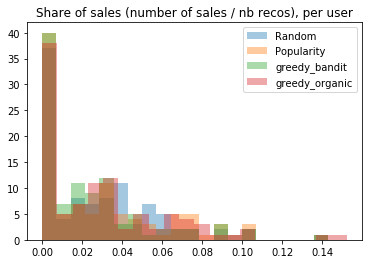

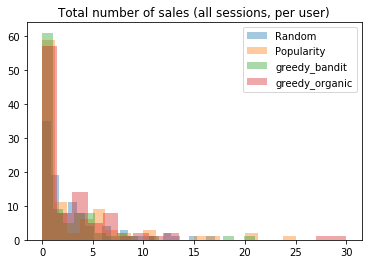

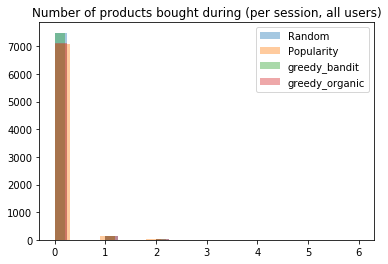

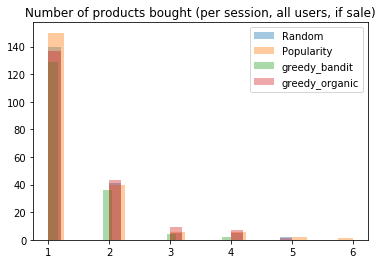

In [12]:
for name,agent in list_agents.items():
    list_sales = list_perfs[name][1]
    # Share of sales for each user (number of sales / recos)
    plt.hist([sum(list_sales[i])/len(list_sales[i]) for i in range(num_online_users)], bins=20, alpha = 0.4, label=name)
    plt.title("Share of sales (number of sales / nb recos), per user")
plt.legend()
plt.show()
    
for name,agent in list_agents.items():
    list_sales = list_perfs[name][1]
    # Total number of sales for a given user
    plt.hist([np.sum(list_sales[i]) for i in range(num_online_users)], bins=20, alpha = 0.4, label=name)
    plt.title("Total number of sales (all sessions, per user)")
plt.legend()
plt.show()
    
for name,agent in list_agents.items():
    list_sales = list_perfs[name][1]
    # Number of products bought
    all_sales = np.array([item for sublist in list_sales for item in sublist])
    plt.hist(all_sales,bins = 20, alpha = 0.4,label=name)
    plt.title("Number of products bought during (per session, all users)")
plt.legend()
plt.show()

for name,agent in list_agents.items():
    list_sales = list_perfs[name][1]
    # Number of products bought
    all_sales = np.array([item for sublist in list_sales for item in sublist])
    plt.hist(all_sales[all_sales>0],bins = 20, alpha = 0.4,label=name)
    plt.title("Number of products bought (per session, all users, if sale)")
plt.legend()
plt.show()

In [18]:
def share_user_with_sale(data):
    '''Input : data (the logs)
    Output : share of users with at least one sale over the entire episode'''
    grouped_data = data[["r","u"]].groupby("u").sum()["r"]
    share = sum(grouped_data>0)/len(data["u"].unique())
    return share
share_user_with_sale(data)

0.65

In [51]:
def log_count_organic_session(data):
    '''
    Input : data (the logs, pandas dataframe)
    Output : the same dataframe, where each session has been numbered (for each user)
    '''
    data_ = data.copy()
    list_organic_sessions = []
    for user in data["u"].unique():
        data_user = data_[data_["u"]==user]
        count_organic_session = 1
        prev_row = "organic"
        for row in range(len(data_user)):
            next_row = data_user["z"].iloc[row]
            if (prev_row == 'bandit') & ((next_row == 'sale') | (next_row == 'organic')):
                count_organic_session += 1
            prev_row = next_row
            list_organic_sessions.append(count_organic_session)
    data_["organic_session"] = list_organic_sessions
    return data_

In [120]:
def share_sale_over_click_session(data):
    '''
    Input : data (the logs)
    Output : (Number of organic sessions with at least one sale / Number of clicks ,
                Number of organic sessions with at least one sale / Number of organic sessions)
    '''
    # Create dataframe that counts the number of organic sessions for each user
    data_ = log_count_organic_session(data)
    # add a boolean for whether there is sale or not
    data_["sale_bool"] = (data_["z"]=='sale')*1
    # Count number of sales  per organic session and user
    sales_per_organic_session = data_[["u","organic_session","sale_bool"]].groupby(["u","organic_session"]).sum()
    # Count number of sales event (dummie) per organic session and user
    sales_per_organic_session["sale_bool"] = (sales_per_organic_session["sale_bool"]>0)*1
    sales_per_organic_session['organic_session'] = [sales_per_organic_session.index[i][1] for i in range(len(sales_per_organic_session))]
    # Don't count sales that may have happened during the first organic session (before a click)
    sales_per_organic_session["sale_bool"] = sales_per_organic_session["sale_bool"]*(sales_per_organic_session["organic_session"]!= 1)
    # Total number of organic sessions (all users)
    nb_organic_sessions = len(sales_per_organic_session)
    # Share of organic sessions that include at least one sale event (all users)
    share_session_with_sale = sum(sales_per_organic_session["sale_bool"])/nb_organic_sessions
    # Number of organic sessions that include at least one sale event over number of clicks (all users)
    share_clicks_with_sale = sum(sales_per_organic_session["sale_bool"])/sum(data["c"]==1)
    
    return share_clicks_with_sale, share_session_with_sale

In [126]:
def share_clicks_with_sale(data):
    return len(data[(data["c"]==1) & (data["r"]>0)])/sum(data["c"]==1)

In [127]:
share_clicks_with_sale(data)

0.42528735632183906

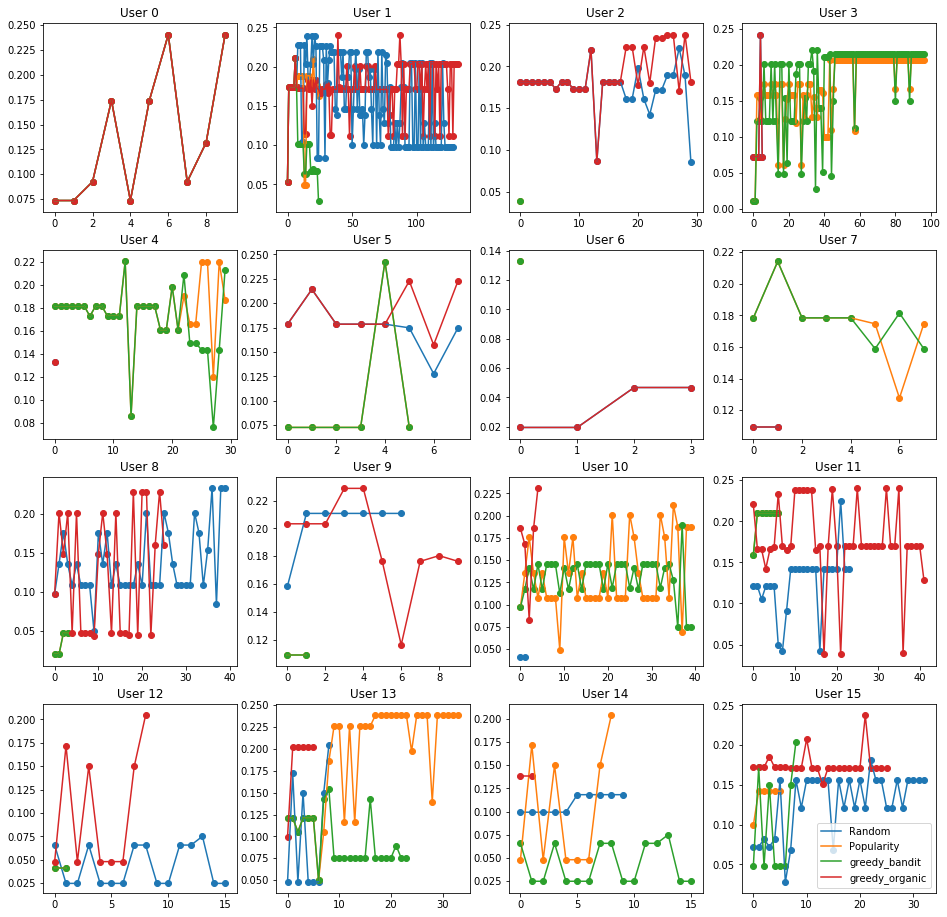

In [16]:
fig, axs = plt.subplots(4, 4, figsize = (16,16))
for i in range(4):
    for j in range(4):
        for name,agent in list_agents.items():
            list_proba_after_scaling = list_perfs[name][3]
            axs[i, j].plot(range(len(list_proba_after_scaling[i*4+j][0])),
                           list_proba_after_scaling[i*4+j][0],
                       label=name)
            axs[i, j].scatter(range(len(list_proba_after_scaling[i*4+j][0])),
                           list_proba_after_scaling[i*4+j][0])
            axs[i,j].set_title("User "+str(i*4+j))
plt.legend()
plt.show()